In [58]:
!pip install netCDF4
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture
from sklearn.linear_model import LinearRegression

import netCDF4
from netCDF4 import Dataset
import pathlib


import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Lambda
from keras.layers import Flatten
from keras.layers import Dropout
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#import tensorflow_docs.modeling
from keras.callbacks import EarlyStopping
import xarray as xr

import torch
import torch.nn as nn
import torch.nn.functional as f

from datetime import date
import datetime

In [0]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

from torch.autograd import Variable

# Functions

#ResNet implementation


In [60]:

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Select the Aghulas region in the dataset (2004 period)



In [61]:
ds = xr.open_dataset("/content/gdrive/My Drive/dataset/SST_SSH_U_V_SLA_global_2004.nc")
print(ds.sizes)
ds

Frozen(SortedKeysDict({'lon': 1440, 'lat': 720, 'time': 366}))


<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 366)
Coordinates:
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * time     (time) datetime64[ns] 2004-01-01T12:00:00 ... 1981-01-01
Data variables:
    SST      (time, lat, lon) float32 ...
    SSH      (time, lon, lat) float32 ...
    U        (time, lon, lat) float32 ...
    V        (time, lon, lat) float32 ...
    SLA      (time, lon, lat) float32 ...
Attributes:
    CDI:                    Climate Data Interface version 1.5.3 (http://code...
    Conventions:            CF-1.0
    history:                Mon Jul 21 17:26:58 2014: cdo merge SST_SSH_U_V_g...
    title:                  Analysed foundation sea surface temperature, global
    DSD_entry_id:           REMSS-L4LRfnd-GLOB-tmi_amsre_OI
    references:             none
    source_data:            TMI-REMSS,AMSRE-REMSS
    contact:                support@remss.com
    GDS_version_id:         GDS-v1.0-rev1.6
    netcdf_version_id:      3.5.0
    creation_date:          2010-08-04
    product_version:        v03
    spatial_resolution:     25 km
    start_date:             2003-12-30
    start_time:             00:00:00 UTC
    stop_date:              2004-01-03
    stop_time:              23:59:59 UTC
    southernmost_latitude:  -89.875
    northernmost_latitude:  89.875
    westernmost_longitude:  -179.875
    easternmost_longitude:  179.875
    file_quality_index:     1
    comment:                www.remss.com for more infomation on product
    CDO:                    Climate Data Operators version 1.5.3 (http://code...

<xarray.DataArray 'SSH' (time: 12, lat: 72, lon: 48)>
array([[[ -5.574714,  -6.155329, ..., -34.895947, -33.42079 ],
        [ -0.572258,  -3.527388, ..., -31.192028, -28.516459],
        ...,
        [       nan, 113.63799 , ...,  98.154755,  99.09104 ],
        [       nan,        nan, ...,  98.69932 ,  98.55898 ]],

       [[ -5.658106,  -6.327619, ..., -35.525436, -33.864185],
        [ -0.544024,  -3.541416, ..., -31.856031, -29.049414],
        ...,
        [       nan, 112.69552 , ...,  97.60034 ,  98.748795],
        [       nan,        nan, ...,  98.0821  ,  98.23634 ]],

       ...,

       [[ -5.6123  ,  -7.397834, ..., -42.283535, -40.40145 ],
        [ -0.696458,  -4.263872, ..., -37.570095, -35.25012 ],
        ...,
        [       nan, 100.381996, ...,  97.1305  ,  98.56167 ],
        [       nan,        nan, ...,  97.77205 ,  97.48329 ]],

       [[ -5.573909,  -7.503035, ..., -42.911316, -41.102127],
        [ -0.75783 ,  -4.403431, ..., -38.07751 , -35.872807],
        ...,
        [       nan,  98.513695, ...,  97.75286 ,  99.09238 ],
        [       nan,        nan, ...,  98.580444,  98.0345  ]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 30.125 30.375 30.625 30.875 ... 41.375 41.625 41.875
  * lat      (lat) float32 -47.875 -47.625 -47.375 ... -30.625 -30.375 -30.125
  * time     (time) datetime64[ns] 2004-01-01T12:00:00 ... 2004-01-12T12:00:00
Attributes:
    long_name:        H
    units:            cm
    _CoordinateAxes:  time NbLongitudes NbLatitudes

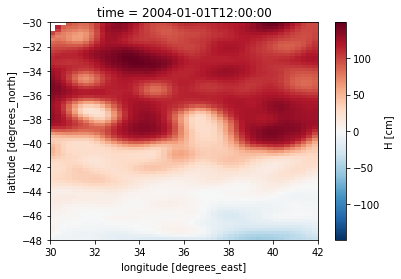

In [62]:
ds_cut = ds.sel(lon=slice(30,42),lat=slice(-48,-30))
ds_cut = ds_cut.isel(time=slice(0,12))
#ds_cut.SST[0].plot()
SSH = ds_cut.SSH.transpose('time','lat','lon')
SSH[0].plot()
SSH

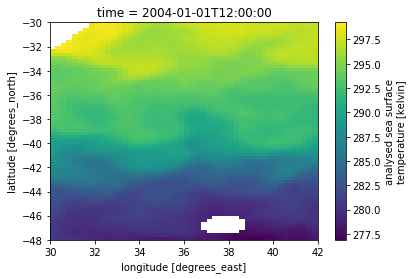

In [63]:
SST = ds_cut.SST
SST[0].plot()

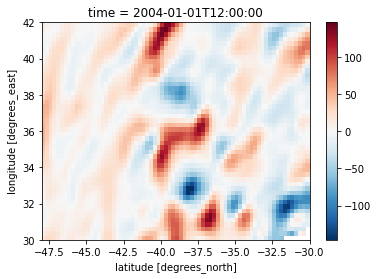

In [64]:
U = ds_cut.U
V = ds_cut.V
UV = U + V
UV[0].plot()

# Create one row with temperature profile and patch data

Concatenate SST and SSH in a single row


In [50]:
ssh = SSH.isel()#.stack(features=('latitude','longitude'))
sst = SST.isel()#.stack(features=('latitude','longitude'))
u = U.isel()
v = V.isel()
# Reduce the size 
sst = sst[:,range(5,7),range(5,7)].stack(features=('lat','lon')) # 5X5

ssh = ssh[:,range(5,7),range(5,7)].stack(features=('lat','lon')) # 5X5
u = u[:,range(5,7),range(5,7)].stack(features=('lat','lon'))
v = v[:,range(5,7),range(5,7)].stack(features=('lat','lon'))
# Possibly normalise features:
#temp = (temp - np.mean(temp))/np.std(temp)  # Normalize by depth
#sla = (sla - np.mean(sla))/np.std(sla)
#sst = (sst - np.mean(sst))/np.std(sst)

# Merge:
features = np.concatenate((sst, ssh, u, v), axis=1)
print(features.shape)

(12, 16)


In [51]:
lat = ds_cut['lat'].isel()
lon = ds_cut['lon'].isel()
lat
#lat= lat[:,6,6].values
#long = lon[:,6,6].values

<xarray.DataArray 'lat' (lat: 72)>
array([-47.875, -47.625, -47.375, -47.125, -46.875, -46.625, -46.375, -46.125,
       -45.875, -45.625, -45.375, -45.125, -44.875, -44.625, -44.375, -44.125,
       -43.875, -43.625, -43.375, -43.125, -42.875, -42.625, -42.375, -42.125,
       -41.875, -41.625, -41.375, -41.125, -40.875, -40.625, -40.375, -40.125,
       -39.875, -39.625, -39.375, -39.125, -38.875, -38.625, -38.375, -38.125,
       -37.875, -37.625, -37.375, -37.125, -36.875, -36.625, -36.375, -36.125,
       -35.875, -35.625, -35.375, -35.125, -34.875, -34.625, -34.375, -34.125,
       -33.875, -33.625, -33.375, -33.125, -32.875, -32.625, -32.375, -32.125,
       -31.875, -31.625, -31.375, -31.125, -30.875, -30.625, -30.375, -30.125],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -47.875 -47.625 -47.375 ... -30.625 -30.375 -30.125
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [65]:
df = ds_cut.to_dataframe()
#dfy = ssh_32.to_dataframe()
#df.dropna()
df.describe()

,SST,SSH,U,V,SLA
count,40500.000000,41412.000000,41364.000000,41364.000000,41472.000000
mean,289.664276,64.655746,6.411788,-0.070271,2.489863
std,6.153758,53.301701,21.215746,25.168777,19.469158
min,276.899994,-55.868542,-87.633102,-112.401688,-83.590195
25%,283.500000,11.294086,-4.592491,-8.285192,-4.559412
50%,291.899994,72.345314,4.140983,0.398307,1.157793
75%,294.600006,115.131859,16.015892,10.451034,10.676555
max,300.600006,156.009079,100.164955,115.808044,77.775757


In [66]:
for v in ds_cut.data_vars:
    print('{:>10}: {}'.format(v, ds[v].attrs['long_name']))

       SST: analysed sea surface temperature
       SSH: H
         U: U
         V: V
       SLA: H


## I - Remove Nan Value

In [67]:
df2 = df.fillna(df.mean())
df2.describe()

,SST,SSH,U,V,SLA
count,41472.000000,41472.000000,41472.000000,41472.000000,41472.000000
mean,289.667908,64.655884,6.411782,-0.070271,2.489863
std,6.081239,53.263115,21.188105,25.135983,19.469158
min,276.899994,-55.868542,-87.633102,-112.401688,-83.590195
25%,283.799988,11.361397,-4.565167,-8.247753,-4.559412
50%,291.750000,72.005962,4.190631,0.358250,1.157793
75%,294.449982,115.106441,15.983466,10.422707,10.676555
max,300.600006,156.009079,100.164955,115.808044,77.775757


#Generate patchs

In [68]:
from sklearn.feature_extraction import image

# Create the array that contains all the SSH, SST, U, V patchs, dim: 1D
SSH_patches = np.empty(([12,2161,169]))
SST_patches = np.empty(([12,2161,169]))
U_patches = np.empty(([12,2161,169]))
V_patches = np.empty(([12,2161,169]))

#fill NaN values with the mean of the SSH, SST, U, V mean
SSHf = SSH.fillna(SSH.mean())
print('SSH shape: {}'.format(SSH.shape))

SSTf = SST.fillna(SST.mean())
print('SST shape: {}'.format(SST.shape))

Uf = U.fillna(U.mean())
print('U shape: {}'.format(U.shape))

Vf = V.fillna(V.mean())
print('V shape: {}'.format(V.shape))

#for each time step, compute patches of size (13x13), flatten them in 1D and concatenate them in SSH_patches, SST_patches, U_patches, V_patches
#output : 1D array of SSH patchs
for i in range(ds_cut.time.shape[0]):
  print("Round : "+ str(i))
  patchesH = image.extract_patches_2d(SSHf[i], (13, 13)) 
  print(" SSH_patches shape " + str(SSH_patches.shape) )

  patchesT = image.extract_patches_2d(SSTf[i], (13, 13)) 
  print(" SST_patches shape " + str(SST_patches.shape) )

  patchesU = image.extract_patches_2d(Uf[i], (13, 13)) 
  print(" U_patches shape " + str(U_patches.shape) )

  patchesV = image.extract_patches_2d(Vf[i], (13, 13)) 
  print(" V_patches shape " +str(V_patches.shape) )

  SSH_p = np.empty(([169]))
  SST_p = np.empty(([169]))
  U_p = np.empty(([169]))
  V_p = np.empty(([169]))

  # for each patch generated, flatten the patch in 1D and stack it
  for j in range(patchesH.shape[0]):
    flath = np.ravel(patchesH[j])
    SSH_p = np.vstack((SSH_p,flath))

    flatt = np.ravel(patchesT[j])
    SST_p = np.vstack((SST_p,flatt))

    flatU = np.ravel(patchesU[j])
    U_p = np.vstack((U_p,flatU))

    flatV = np.ravel(patchesV[j])
    V_p = np.vstack((V_p,flatV))

  print("SSH " + str(SSH_patches[i].shape))
  print("p " + str(SSH_p.shape))
  SSH_patches[i] = SSH_p

  """SSH_patches = np.stack((SSH_patches,SSH_p))
  SST_patches = np.stack((SST_patches,SST_p))
  U_patches = np.stack((U_patches,U_p))
  V_patches = np.stack((V_patches,V_p))"""

print('Patches shape: {}'.format(SST_patches.shape))
print('Patches shape: {}'.format(SSH_patches.shape))
print('Patches shape: {}'.format(U_patches.shape))
print('Patches shape: {}'.format(V_patches.shape))


SSH shape: (12, 72, 48)
SST shape: (12, 72, 48)
U shape: (12, 48, 72)
V shape: (12, 48, 72)
Round : 0
 SSH_patches shape (12, 2161, 169)
 SST_patches shape (12, 2161, 169)
 U_patches shape (12, 2161, 169)
 V_patches shape (12, 2161, 169)
SSH (2161, 169)
p (2161, 169)
Round : 1
 SSH_patches shape (12, 2161, 169)
 SST_patches shape (12, 2161, 169)
 U_patches shape (12, 2161, 169)
 V_patches shape (12, 2161, 169)
SSH (2161, 169)
p (2161, 169)
Round : 2
 SSH_patches shape (12, 2161, 169)
 SST_patches shape (12, 2161, 169)
 U_patches shape (12, 2161, 169)
 V_patches shape (12, 2161, 169)
SSH (2161, 169)
p (2161, 169)
Round : 3
 SSH_patches shape (12, 2161, 169)
 SST_patches shape (12, 2161, 169)
 U_patches shape (12, 2161, 169)
 V_patches shape (12, 2161, 169)
SSH (2161, 169)
p (2161, 169)
Round : 4
 SSH_patches shape (12, 2161, 169)
 SST_patches shape (12, 2161, 169)
 U_patches shape (12, 2161, 169)
 V_patches shape (12, 2161, 169)
SSH (2161, 169)
p (2161, 169)
Round : 5
 SSH_patches shape

#Reshape the patches


## II - Training of the compMLP

#Description of the model

In [0]:
class comp_MLP :
  def __init__(self, number_mode, X_train, y_train, X_test, y_test):
    self.number_mode = number_mode
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test

  def create_model(self):
    #for i in range(1, self.number_mode)
    model = Sequential()
    #get number of columns in training data
    input_shape = self.X_train[0].shape

    #compile model using mse as a measure of model performance
    model.compile(optimizer='adam', loss='mean_squared_error')

 # Define the tensors for the two input images
    input = Input(input_shape)
    
    model.add(Dense(75, input_shape=input_shape, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    # Generate the encodings (feature vectors) for the two images
    mlp_out_1 = model(input)
    mlp_out_2 = model(input)
    mlp_out_3 = model(input)
    mlp_out_4 = model(input)


    wiw = tf.convert_to_tensor(self.X_train[1], dtype=tf.float32)
    # Add a customized layer to compute the absolute difference between the encodings
    w_layer = Lambda(lambda tensors: tensors[0] - tensors[1])
    W1 = w_layer([wiw, mlp_out_1])
    W2 = w_layer([wiw, mlp_out_2])
    W3 = w_layer([wiw, mlp_out_3])
    W4 = w_layer([wiw, mlp_out_4])
    

    #NEED TO REPLICATE THE WEIGHT FROM Kx1 TO Kx3
    partial_pred_layer =  Lambda(lambda tensors: tensors[0] * tensors[1])
    partial_pred_1 = partial_pred_layer([mlp_out_1, W1])
    partial_pred_2 = partial_pred_layer([mlp_out_2, W2])
    partial_pred_3 = partial_pred_layer([mlp_out_3, W3])
    partial_pred_4 = partial_pred_layer([mlp_out_4, W4])


    Y_pred_layer =  Lambda(lambda tensors: tensors[0] + tensors[1] + tensors[2] + tensors[3])
    Y_pred = Y_pred_layer([partial_pred_1, partial_pred_2, partial_pred_3, partial_pred_4 ])
   
    # Connect the inputs with the outputs
    comp_mlp = Model(inputs=[input_1,input_2,input_3,input_4],outputs=prediction)
    
    # return the model
    return comp_mlp

    def train(self):
          
      #set early stopping monitor so the model stops training when it won't improve anymore
      early_stopping_monitor = EarlyStopping(patience=3)
      #train model
      model.fit(self.X_train, self.y_train, epochs=10, batch_size=250, verbose=1, validation_split=0.2, callbacks=[early_stopping_monitor])

    def predict(self):
      test_y_predictions = model.predict(self.X_test)

In [94]:
X = np.stack((SST_patches,SSH_patches, U_patches, V_patches))
print(X[0].shape)

y = np.vstack((SSH_patches, U_patches, V_patches)) 
# Split the data into training/testing sets
X_train = X[:,:9]
X_test = X[:,3:]
print(X_train.shape)
# Split the targets into training/testing sets
y_train = y[:9]
y_test = y[3:]

input_shape = (X_train.shape[1],)
print(input_shape)

#create model
modelCMLP = comp_MLP(4,X_train,y_train, X_test, y_test)

modelCMLP.create_model()

modelCMLP.train

modelCMLP.predict()

"""
model = Sequential()

model.add(Dense(75, input_shape=input_shape, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3))

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse'])
history = model.fit(X_train, y_train, epochs=10, batch_size=320)"""

(12, 2161, 169)
(4, 9, 2161, 169)
(9,)


ValueError: ignored

(11814, 1)
Coefficients: 
 [tensor(0.), tensor(0.), tensor(0.)]


NameError: ignored

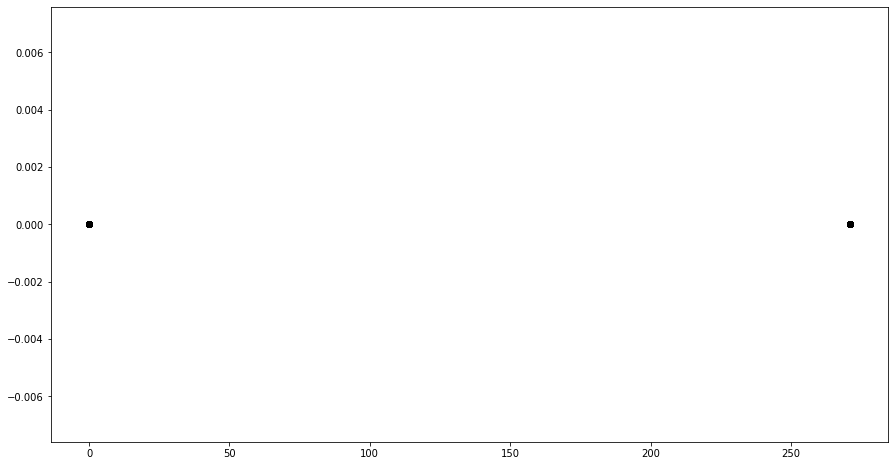

In [0]:
X_test = np.reshape(X_test,(-1,1))
print(X_test.shape)

print('Coefficients: \n', loss_list)
# The mean squared error


# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()